In [1]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import PIL
import PIL.Image
import cv2

from tqdm import tqdm
from pprint import pprint

In [2]:
# Lets check your GPU
if tf.config.list_logical_devices('GPU') != []:
    print("LET'S DO THISS!!! :DDDD")
else: 
    print("Oh dude... D:")

LET'S DO THISS!!! :DDDD


### Dataset images

You can find dataset images celeba in here: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

Download it, and create a directory called "./img_align_celeba", save all images right there. 

# 1) Load data

In [3]:
'''

Lets define some dir to save iamges.

'''

from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
path = "./img_align_celeba"
data_dir = pathlib.Path(path)

# Lets check quantity
image_count = len(list(data_dir.glob('*.jpg')))
print('We have', image_count, 'images.')

We have 202599 images.


In [5]:
# Get all paths
all_paths = [str(x) for x in list(data_dir.glob('*.jpg'))]

## 1.1) Slice dataset in train-val-test

In [6]:
train_path = all_paths[:int(image_count * 0.8)]
val_path = all_paths[int(image_count * 0.8): int(image_count * 0.9)]
test_path = all_paths[int(image_count * 0.9):]

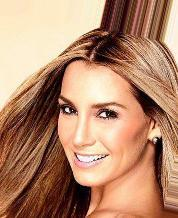

In [7]:
# Sanity check!
PIL.Image.open(train_path[0])

## 1.2) Let's preprocessing all images with tf dataset

In [8]:
# Instanciate tf datasets
ds_train_path = tf.data.Dataset.from_tensor_slices(train_path)
ds_val_path = tf.data.Dataset.from_tensor_slices(val_path)
ds_test_path = tf.data.Dataset.from_tensor_slices(test_path)

In [9]:
'''

Open all images and resize.

'''

def open_image(x):
    return tf.ensure_shape(tf.image.decode_image(tf.io.read_file(x)), [218, 178, 3])

def resize_image(x, n_outputs=2):
    if n_outputs == 2:
        return (tf.image.resize(x, [128, 128]) / 255., tf.image.resize(x, [128, 128]) / 255.)
    return tf.image.resize(x, [128, 128]) / 255.

ds_train = ds_train_path.map(
    lambda x: resize_image(open_image(x), n_outputs=2)
)

ds_val = ds_val_path.map(
    lambda x: resize_image(open_image(x), n_outputs=2)
)

ds_test = ds_test_path.map(
    lambda x: resize_image(open_image(x), n_outputs=2)
)

## 2) Create simple VAE Architecture (with Sobel loss function)

We will use sobel filter to build a function that will help neural network learn high frequency features.

In [10]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [ ]:
codings_size = 100

inputs = keras.layers.Input(shape=[128, 128, 3])
# Z = keras.layers.Conv2D(16, 4, padding="same", activation="relu")(inputs)
# Z = keras.layers.MaxPool2D(pool_size=2)(Z)

Z = keras.layers.Conv2D(32, 4, padding="same", activation="relu")(inputs)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Conv2D(64, 4, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Conv2D(128, 4, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Conv2D(256, 4, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.GlobalAvgPool2D()(Z) # Output 256
Z = keras.layers.Flatten()(Z)

codings_mean = keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = keras.layers.Dense(codings_size)(Z)  # γ

# ---------

codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
    inputs=inputs, outputs=[codings_mean, codings_log_var, codings])


decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(4 * 4 * 256)(decoder_inputs)
x = keras.layers.Reshape((4, 4, 256))(x)

x = keras.layers.Conv2DTranspose(256, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(128, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(64, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(32, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)


x = keras.layers.Conv2DTranspose(3, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)


outputs = keras.layers.Reshape([128, 128, 3])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
_, _, codings = variational_encoder([inputs])
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=inputs, outputs=[reconstructions])

latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)

variational_ae.add_loss(tf.reduce_mean(latent_loss) / (128. * 128.))

In [ ]:
'''

Aditional loss:

If you see outputs of regular VAE, the reconstructions have some blurr. Let's try to fix it using sobel loss function. We will compute gradients from inputs and reconstructions, take the difference and minimizes MSE from both.

'''

sobel = tf.image.sobel_edges(inputs)
sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

sobel_hat = tf.image.sobel_edges(reconstructions)
sobel_y_hat = sobel_hat[:, :, :, :, 0] # sobel in y-direction
sobel_x_hat = sobel_hat[:, :, :, :, 1] # sobel in x-direction

loss_sobel_x = tf.reduce_sum( (sobel_x - sobel_x_hat) * (sobel_x - sobel_x_hat), axis=-1)
loss_sobel_y = tf.reduce_sum( (sobel_y - sobel_y_hat) * (sobel_y - sobel_y_hat), axis=-1)


variational_ae.add_loss(1.5 * tf.reduce_mean(loss_sobel_x) / (128. * 128.))
variational_ae.add_loss(1.5 * tf.reduce_mean(loss_sobel_y) / (128. * 128.))

In [ ]:
variational_ae.compile(loss='mse', optimizer="adam")

In [ ]:
dataset_train = ds_train.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)
dataset_val = ds_val.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)

In [18]:
from IPython.display import clear_output
def plot_multiple_images(images, n_cols=None, k=1):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        clear_output()
        plt.axis("off")

In [ ]:
for epoch in tqdm(range(30)):
    for X_batch_1 in dataset_train:
        # Fase 0 - Treinar a rede VAE
        
        variational_ae.train_on_batch(X_batch_1[0], X_batch_1[1])
        generated_images = variational_ae(X_batch_1[0])
    plot_multiple_images(generated_images.numpy(), 8)
    plt.show()

  0%|                                                                                           | 0/30 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [ ]:

'''

Saving models after training...

'''

# variational_ae.save('vae_sobel_t_1_5/autoencoder/vae_sobel_autoencoder.keras')
# variational_encoder.save('vae_sobel_t_1_5/encoder/vae_sobel_encoder.keras')
# variational_decoder.save('vae_sobel_t_1_5/decoder/vae_sobel_decoder.keras')

## Organizing architecture and sobel loss

In [26]:
def sobel_loss(X_input, X_reconstruction, gamma=32.0):

    sobel = tf.image.sobel_edges(X_input)
    sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
    sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

    sobel_hat = tf.image.sobel_edges(X_reconstruction)
    sobel_y_hat = sobel_hat[:, :, :, :, 0] # sobel in y-direction
    sobel_x_hat = sobel_hat[:, :, :, :, 1] # sobel in x-direction

    loss_sobel_x = tf.reduce_sum( tf.abs(sobel_x - sobel_x_hat) , axis=-1)
    loss_sobel_y = tf.reduce_sum( tf.abs(sobel_y - sobel_y_hat) , axis=-1)
    
    loss_sobel_x = gamma * tf.reduce_mean(loss_sobel_x) / (128. * 128.)
    loss_sobel_y = gamma * tf.reduce_mean(loss_sobel_y) / (128. * 128.)
    

    return loss_sobel_x + loss_sobel_y


def build_vae_sobel_model(codings_size=100):
    # codings_size = 100

    inputs = keras.layers.Input(shape=[128, 128, 3])
    # Z = keras.layers.Conv2D(16, 4, padding="same", activation="relu")(inputs)
    # Z = keras.layers.MaxPool2D(pool_size=2)(Z)

    Z = keras.layers.Conv2D(32, 4, padding="same", activation="relu")(inputs)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(64, 4, padding="same", activation="relu")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(128, 4, padding="same", activation="relu")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(256, 4, padding="same", activation="relu")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.GlobalAvgPool2D()(Z) # Output 256
    Z = keras.layers.Flatten()(Z)

    codings_mean = keras.layers.Dense(codings_size)(Z)  # μ
    codings_log_var = keras.layers.Dense(codings_size)(Z)  # γ

    # ---------

    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = keras.Model(
        inputs=inputs, outputs=[codings_mean, codings_log_var, codings])


    decoder_inputs = keras.layers.Input(shape=[codings_size])
    x = keras.layers.Dense(4 * 4 * 256)(decoder_inputs)
    x = keras.layers.Reshape((4, 4, 256))(x)

    x = keras.layers.Conv2DTranspose(256, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(128, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(64, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(32, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)


    x = keras.layers.Conv2DTranspose(3, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)


    outputs = keras.layers.Reshape([128, 128, 3])(x)
    variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])
    
    _, _, codings = variational_encoder([inputs])
    reconstructions = variational_decoder(codings)
    variational_ae = tf.keras.Model(inputs=inputs, outputs=[reconstructions])

    latent_loss = -0.5 * tf.reduce_sum(
        1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
        axis=-1)

    variational_ae.add_loss(tf.reduce_mean(latent_loss) / (128. * 128.))
    # variational_ae.add_loss(sobel_loss(inputs, reconstructions))
   
    # variational_ae.compile(loss=['mse', sobel_loss], optimizer="adam")
    
    return variational_encoder, variational_decoder, variational_ae

In [27]:
dataset_train = ds_train.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)
dataset_val = ds_val.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)

In [28]:
encoder, decoder, variational_ae = build_vae_sobel_model()

In [29]:
from IPython.display import clear_output
def plot_multiple_images(images, n_cols=None, k=1):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        clear_output()
        plt.axis("off")

In [49]:
def plot_losses(history):
    epochs = np.array(list(range(1, len(history['loss_reconstruction']) + 1))) * 10
    
    plt.figure(figsize=(6, 6))
    
    plt.plot(epochs, history['loss_reconstruction'], 'b', label='Loss Reconstruction')
    plt.plot(epochs, history['loss_sobel'], 'r', label='Loss Sobel')
    plt.plot(epochs, history['loss_dkl'], 'g', label='Loss DKL')
    plt.plot(epochs, history['total_loss'], 'y', label='Total Loss')
    
    plt.title('Training Losses')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.grid(True)
    plt.show()

In [50]:
def print_logs(history, epoch, total_epochs, n_batch, step):
    print('------------Losses---------------')
    print('loss_reconstruction: ',  history['loss_reconstruction'][-1])
    print('loss_sobel: ',  history['loss_sobel'][-1])
    print('loss_dkl: ',  history['loss_dkl'][-1])
    print('total_loss: ',  history['total_loss'][-1])
    print('---------------------------------')
    print(f'Epoch: {epoch}/{total_epochs}')
    print(f'N Batch: {n_batch}')
    print(f'Step: {step}')

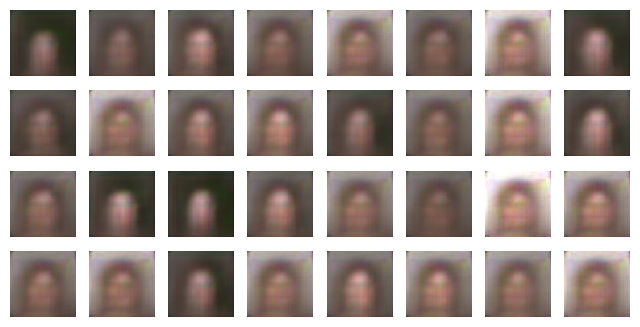

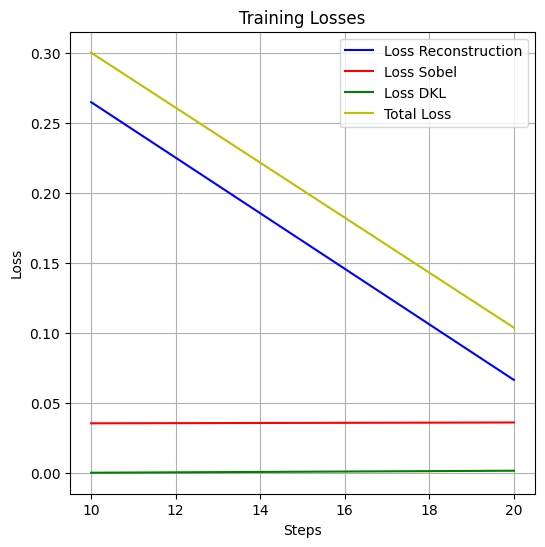

------------Losses---------------
loss_reconstruction:  tf.Tensor(0.066257484, shape=(), dtype=float32)
loss_sobel:  tf.Tensor(0.035873596, shape=(), dtype=float32)
loss_dkl:  tf.Tensor(0.0014319919, shape=(), dtype=float32)
total_loss:  tf.Tensor(0.10356307, shape=(), dtype=float32)
---------------------------------
Epoch: 0/30
N Batch: 100
Step: 100


  0%|                                                                                           | 0/30 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [32]:
history = {
            'loss_reconstruction': [],
            'loss_sobel': [],
            'loss_dkl': [],
            'total_loss': []
        }

MSE = keras.losses.MeanSquaredError()
SobelLoss = sobel_loss
optimizer = keras.optimizers.Adam()
total_epochs = 30
step = 0
for epoch in tqdm(range(total_epochs)):
    n_batch = 0
    for X_batch_1 in dataset_train:
        with tf.GradientTape() as tape:
            # Forward pass.
            X_reconstructions = variational_ae(X_batch_1[0])
            # Loss reconstruction
            loss_reconstruction = MSE(X_batch_1[1], X_reconstructions)
            # Loss sobel
            loss_sobel = SobelLoss(X_batch_1[0], X_reconstructions, gamma=512.0)
            # Add extra loss terms to the loss value.
            loss_total = sum(variational_ae.losses) + loss_reconstruction + loss_sobel
        
        gradients = tape.gradient(loss_total, variational_ae.trainable_weights)
        optimizer.apply_gradients(zip(gradients, variational_ae.trainable_weights))
        
        if step % 100 == 0:
            
            history['loss_reconstruction'].append(loss_reconstruction)
            history['loss_sobel'].append(loss_sobel)
            history['loss_dkl'].append(sum(variational_ae.losses))
            history['total_loss'].append(loss_total)
    
            generated_images = variational_ae(X_batch_1[0])
            plot_multiple_images(generated_images.numpy(), 8)
            plot_losses(history)
            print_logs(history, epoch, total_epochs, n_batch, step)
            plt.show()
        n_batch += 1
        step += 1


## 3) VAE with sobel loss function and Sin activation function

In [124]:
from keras import backend as K

def sin(x, beta=1.0):
    return K.sin(beta * x)

In [125]:
def quadratic_sobel_loss(X_input, X_reconstruction, gamma=32.0):

    sobel = tf.image.sobel_edges(X_input)
    sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
    sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

    sobel_hat = tf.image.sobel_edges(X_reconstruction)
    sobel_y_hat = sobel_hat[:, :, :, :, 0] # sobel in y-direction
    sobel_x_hat = sobel_hat[:, :, :, :, 1] # sobel in x-direction

    loss_sobel_x = tf.reduce_sum( tf.square(sobel_x - sobel_x_hat) , axis=-1)
    loss_sobel_y = tf.reduce_sum( tf.square(sobel_y - sobel_y_hat) , axis=-1)
    
    loss_sobel_x = gamma * tf.reduce_mean(loss_sobel_x) / (128. * 128.)
    loss_sobel_y = gamma * tf.reduce_mean(loss_sobel_y) / (128. * 128.)
    

    return loss_sobel_x + loss_sobel_y

def complete_sobel_loss(X_input, X_reconstruction, gamma=32.0):

    sobel = tf.image.sobel_edges(X_input)
    sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
    sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

    sobel_hat = tf.image.sobel_edges(X_reconstruction)
    sobel_y_hat = sobel_hat[:, :, :, :, 0] # sobel in y-direction
    sobel_x_hat = sobel_hat[:, :, :, :, 1] # sobel in x-direction
    
    gradient_input = sobel_x ** 2 + sobel_y ** 2
    
    gradient_reconstruction = sobel_x_hat ** 2 + sobel_y_hat ** 2
    
    return gamma * tf.reduce_mean(tf.abs(gradient_input - gradient_reconstruction)) / (128. * 128.)

In [126]:
def build_vae_sobel_model_siren(codings_size=100):
    # codings_size = 100

    inputs = keras.layers.Input(shape=[128, 128, 3])

    Z = keras.layers.Conv2D(32, 1, padding="same", activation='tanh')(inputs)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(64, 2, padding="same", activation=sin)(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(128, 3, padding="same", activation=sin)(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(256, 4, padding="same", activation="sigmoid")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.GlobalAvgPool2D()(Z) # Output 256
    Z = keras.layers.Flatten()(Z)

    codings_mean = keras.layers.Dense(codings_size)(Z)  # μ
    codings_log_var = keras.layers.Dense(codings_size)(Z)  # γ

    # ---------

    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = keras.Model(
        inputs=inputs, outputs=[codings_mean, codings_log_var, codings])


    decoder_inputs = keras.layers.Input(shape=[codings_size])
    x = keras.layers.Dense(4 * 4 * 256)(decoder_inputs)
    x = keras.layers.Reshape((4, 4, 256))(x)

    x = keras.layers.Conv2DTranspose(256, 4, padding='same', activation='tanh')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(128, 4, padding='same', activation=sin)(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(64, 3, padding='same', activation=sin)(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(32, 2, padding='same', activation=sin)(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)


    x = keras.layers.Conv2DTranspose(3, 1, padding='same', activation='sigmoid')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)


    outputs = keras.layers.Reshape([128, 128, 3])(x)
    variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])
    
    _, _, codings = variational_encoder([inputs])
    reconstructions = variational_decoder(codings)
    variational_ae = tf.keras.Model(inputs=inputs, outputs=[reconstructions])

    latent_loss = -0.5 * tf.reduce_sum(
        1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
        axis=-1)

    variational_ae.add_loss(tf.reduce_mean(latent_loss) / (128. * 128.))
    
    return variational_encoder, variational_decoder, variational_ae

In [127]:
encoder, decoder, variational_ae = build_vae_sobel_model_siren()

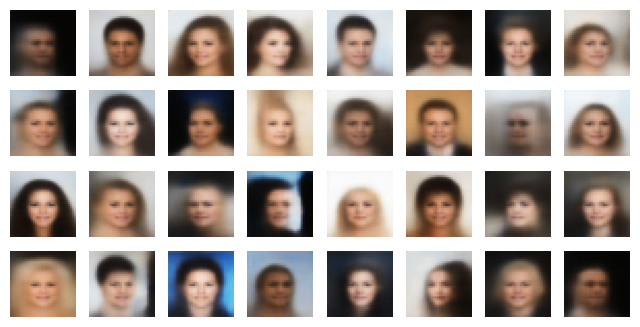

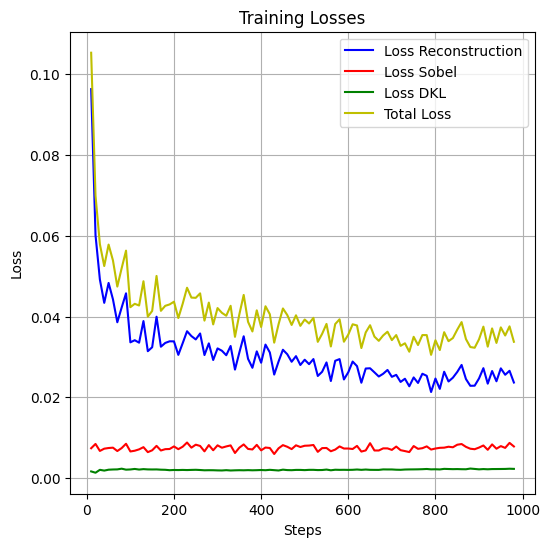

------------Losses---------------
loss_reconstruction:  tf.Tensor(0.023652062, shape=(), dtype=float32)
loss_sobel:  tf.Tensor(0.007820192, shape=(), dtype=float32)
loss_dkl:  tf.Tensor(0.0022665844, shape=(), dtype=float32)
total_loss:  tf.Tensor(0.033738837, shape=(), dtype=float32)
---------------------------------
Epoch: 1/10
N Batch: 4636
Step: 9700


In [ ]:
history = {
            'loss_reconstruction': [],
            'loss_sobel': [],
            'loss_dkl': [],
            'total_loss': []
        }

MSE = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
total_epochs = 10
step = 0
for epoch in tqdm(range(total_epochs)):
    n_batch = 0
    for X_batch_1 in dataset_train:
        with tf.GradientTape() as tape:
            # Forward pass.
            X_reconstructions = variational_ae(X_batch_1[0])
            # Loss reconstruction
            loss_reconstruction = MSE(X_batch_1[1], X_reconstructions)
            # Loss sobel
            loss_sobel = complete_sobel_loss(X_batch_1[0], X_reconstructions, gamma=512.0)
            # Add extra loss terms to the loss value.
            loss_total = sum(variational_ae.losses) + loss_reconstruction + loss_sobel
        gradients = tape.gradient(loss_total, variational_ae.trainable_weights)
        optimizer.apply_gradients(zip(gradients, variational_ae.trainable_weights))
        
        if step % 100 == 0:
            
            history['loss_reconstruction'].append(loss_reconstruction)
            history['loss_sobel'].append(loss_sobel)
            history['loss_dkl'].append(sum(variational_ae.losses))
            history['total_loss'].append(loss_total)
    
            generated_images = variational_ae(X_batch_1[0])
            plot_multiple_images(generated_images.numpy(), 8)
            plot_losses(history)
            print_logs(history, epoch, total_epochs, n_batch, step)
            plt.show()
        n_batch += 1
        step += 1

## Extra - Objective with sobel filter

We want minimize error by difference of gradients, so we can write another loss function:

$$L_{sobel} = f_{sobel}(input) - f_{sobel}(reconstruction)$$

In [42]:
sample = X_batch_1[0][0:1]
reconstruction = variational_ae(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


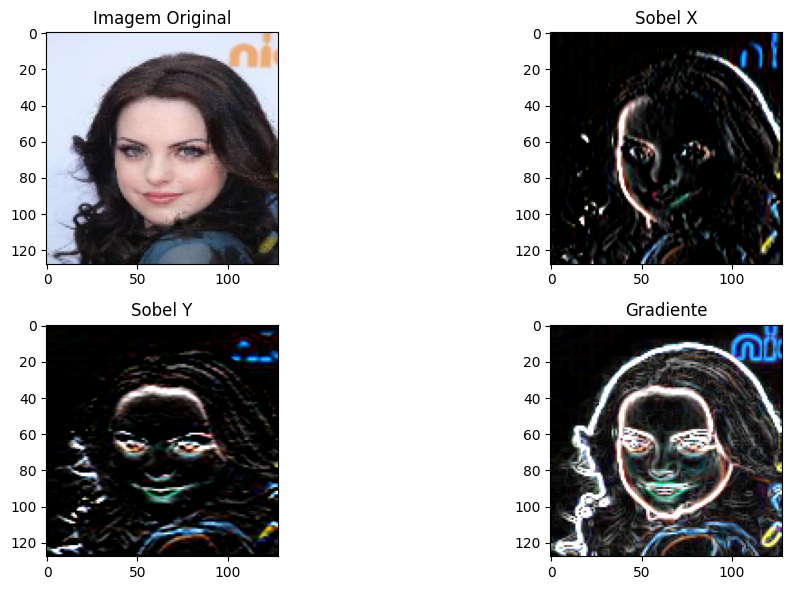

In [43]:
# Aplicar filtro de Sobel
# sobel_x = cv2.Sobel(sample.numpy(), cv2.CV_64F, 1, 0, ksize=3)
# sobel_y = cv2.Sobel(sample.numpy(), cv2.CV_64F, 0, 1, ksize=3)
sobel = tf.image.sobel_edges(sample)
sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

# Calcular o gradiente aproximado
gradiente = tf.sqrt(sobel_x**2 + sobel_y**2)

# Mostrar as imagens
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(sample[0], cmap='gray')
plt.title('Imagem Original')

plt.subplot(2, 2, 2)
plt.imshow(sobel_x[0], cmap='gray')
plt.title('Sobel X')

plt.subplot(2, 2, 3)
plt.imshow(sobel_y[0], cmap='gray')
plt.title('Sobel Y')

plt.subplot(2, 2, 4)
plt.imshow(gradiente[0], cmap='gray')
plt.title('Gradiente')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


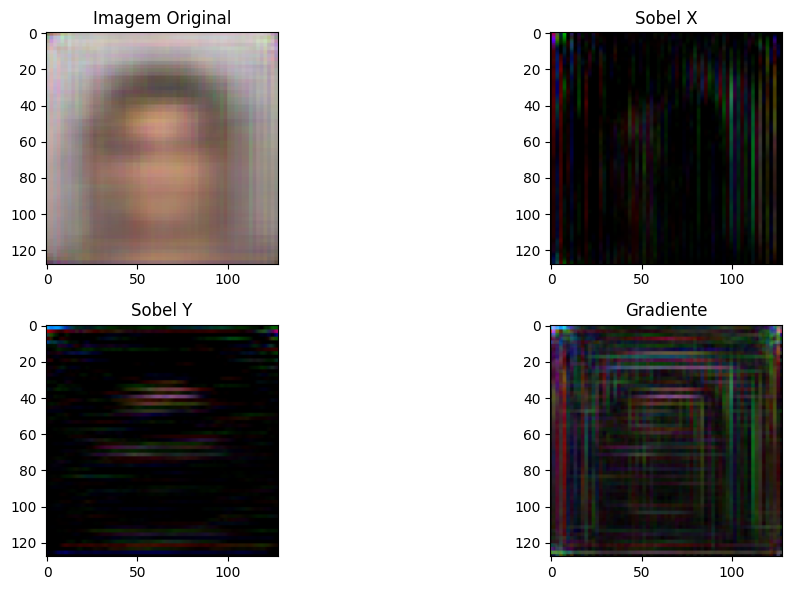

In [44]:
# Aplicar filtro de Sobel
# sobel_x = cv2.Sobel(sample.numpy(), cv2.CV_64F, 1, 0, ksize=3)
# sobel_y = cv2.Sobel(sample.numpy(), cv2.CV_64F, 0, 1, ksize=3)
sobel = tf.image.sobel_edges(reconstruction)
sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

# Calcular o gradiente aproximado
gradiente_reconstruction = tf.sqrt(sobel_x**2 + sobel_y**2)

# Mostrar as imagens
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(reconstruction[0], cmap='gray')
plt.title('Imagem Original')

plt.subplot(2, 2, 2)
plt.imshow(sobel_x[0], cmap='gray')
plt.title('Sobel X')

plt.subplot(2, 2, 3)
plt.imshow(sobel_y[0], cmap='gray')
plt.title('Sobel Y')

plt.subplot(2, 2, 4)
plt.imshow(gradiente_reconstruction[0], cmap='gray')
plt.title('Gradiente')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


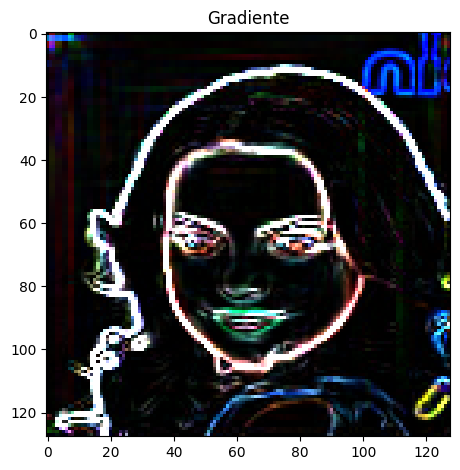

In [45]:
plt.imshow(tf.square(tf.abs(gradiente[0] - gradiente_reconstruction[0])), cmap='gray')
plt.title('Gradiente')

plt.tight_layout()
plt.show()

## 3) DCGAN 

In [112]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 100

generator = tf.keras.Sequential([
    keras.layers.Input(shape=[codings_size]),
    tf.keras.layers.Dense(4 * 4 * 256),
    tf.keras.layers.Reshape((4, 4, 256)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])


discriminator = tf.keras.Sequential([
    keras.layers.Input(shape=[128, 128, 3]),
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [114]:
# extra code – compiles the discrimator and the gan, as earlier
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [115]:
discriminator.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 64, 64, 64)        4864      
                                                                 
 dropout_41 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 128)       204928    
                                                                 
 dropout_42 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 16, 16, 256)       819456    
                                                                 
 dropout_43 (Dropout)        (None, 16, 16, 256)       0         
                                                                 
 conv2d_51 (Conv2D)          (None, 8, 8, 256)       

In [116]:
generator.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 4096)              413696    
                                                                 
 reshape_28 (Reshape)        (None, 4, 4, 256)         0         
                                                                 
 batch_normalization_95 (Bat  (None, 4, 4, 256)        1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_83 (Conv2D  (None, 8, 8, 64)         409664    
 Transpose)                                                      
                                                                 
 conv2d_transpose_84 (Conv2D  (None, 16, 16, 128)      204928    
 Transpose)                                                      
                                                     

In [117]:
from tqdm import tqdm

def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(n_epochs), position=1, desc='Progresso'):
        print(f"Epoch {epoch + 1}/{n_epochs}")  # extra code
        for X_batch in tqdm(dataset):
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
            # extra code — plot images during training
            
        plot_multiple_images(generated_images.numpy()[:32], 8)
        plt.show()

In [121]:
# extra code – generates the dataset and trains the GAN, just like earlier
batch_size = 128
dataset = ds_train.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

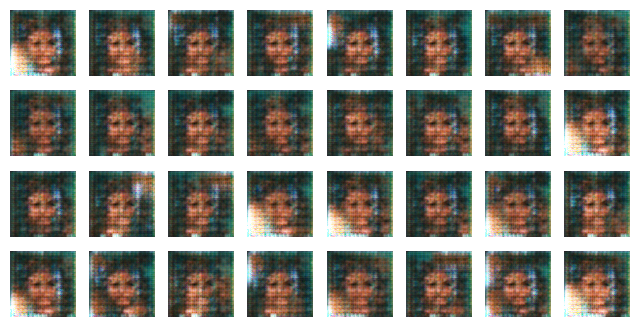


Progresso:   4%|██▉                                                                     | 2/50 [1:19:25<33:31:37, 2514.54s/it]

Epoch 3/50


Progresso:   4%|██▉                                                                     | 2/50 [1:20:20<32:08:06, 2410.13s/it]


KeyboardInterrupt: 

In [122]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)